In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### PARTIE 1 : Exploration de la base de données

In [117]:
df = pd.read_csv('csv_files/regularite-mensuelle-tgv-aqst.csv',sep=';')
missing_data = df.isnull().sum()
print('Donées manquantes :', '\n', missing_data[missing_data>0], '\n')
print('Type des données :', '\n', df.dtypes)

Donées manquantes : 
 commentaire_annulation         8154
commentaire_retards_depart     8154
commentaires_retard_arrivee    7456
dtype: int64 

Type des données : 
 date                                     object
service                                  object
gare_depart                              object
gare_arrivee                             object
duree_moyenne                             int64
nb_train_prevu                            int64
nb_annulation                             int64
commentaire_annulation                  float64
nb_train_depart_retard                    int64
retard_moyen_depart                     float64
retard_moyen_tous_trains_depart         float64
commentaire_retards_depart              float64
nb_train_retard_arrivee                   int64
retard_moyen_arrivee                    float64
retard_moyen_tous_trains_arrivee        float64
commentaires_retard_arrivee              object
nb_train_retard_sup_15                    int64
retard_moyen_train

In [118]:
print("#######################")
print("#### Information : ####")
print("#######################")
print(df.info())

#######################
#### Information : ####
#######################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8154 entries, 0 to 8153
Data columns (total 26 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  8154 non-null   object 
 1   service                               8154 non-null   object 
 2   gare_depart                           8154 non-null   object 
 3   gare_arrivee                          8154 non-null   object 
 4   duree_moyenne                         8154 non-null   int64  
 5   nb_train_prevu                        8154 non-null   int64  
 6   nb_annulation                         8154 non-null   int64  
 7   commentaire_annulation                0 non-null      float64
 8   nb_train_depart_retard                8154 non-null   int64  
 9   retard_moyen_depart                   8154 non-null   float64
 10  retard_moyen

In [119]:
def printing_descr_stat():
    print('Description statistique de chaque colonne : ', '\n', df.describe())


### PARTIE 2 : Traitement de la base de données
#### 1 : Gestion des commentaires

On observe que les seules valeurs manquantes sont pour les features commentaires : commentaire_annulation, commentaire_retards_depart
et commentaire_retard_arrivee.
Pour une première approche simplificatrice du dataset, on prend la décision de supprimier les features commentaires.

In [120]:
df_clean = (
    df.copy()
        .drop(
            ["commentaire_annulation", "commentaire_retards_depart", "commentaires_retard_arrivee"],
            axis=1,
        )
)

df_clean.columns

Index(['date', 'service', 'gare_depart', 'gare_arrivee', 'duree_moyenne',
       'nb_train_prevu', 'nb_annulation', 'nb_train_depart_retard',
       'retard_moyen_depart', 'retard_moyen_tous_trains_depart',
       'nb_train_retard_arrivee', 'retard_moyen_arrivee',
       'retard_moyen_tous_trains_arrivee', 'nb_train_retard_sup_15',
       'retard_moyen_trains_retard_sup15', 'nb_train_retard_sup_30',
       'nb_train_retard_sup_60', 'prct_cause_externe', 'prct_cause_infra',
       'prct_cause_gestion_trafic', 'prct_cause_materiel_roulant',
       'prct_cause_gestion_gare', 'prct_cause_prise_en_charge_voyageurs'],
      dtype='object')

#### 2 : Gestion de la colonne service

In [121]:
df_clean["service"].unique()

array(['National', 'International'], dtype=object)

On observe que la colonne ne possède que deux valeurs categorielles, nous allons faire un "one-hot" encoding et creer une feature booléenne "national_service"

In [122]:
df_clean["national_service"] = np.where(df_clean["service"]=="National", 1,0)
df_clean.drop("service", axis=1, inplace=True)

#### 3 : Gestion de la date
Nous allons créer deux colonnes, une pour le mois et l'autre pour l'année.


In [123]:
df_clean[['annee', 'mois']] = df_clean['date'].str.split('-', expand=True)
df_clean.drop("date", axis=1, inplace=True)
df_clean[:4]


,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_annulation,nb_train_depart_retard,retard_moyen_depart,retard_moyen_tous_trains_depart,nb_train_retard_arrivee,retard_moyen_arrivee,...,nb_train_retard_sup_60,prct_cause_externe,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs,national_service,annee,mois
0,PARIS LYON,AIX EN PROVENCE TGV,186,424,0,49,10.284354,0.906840,47,36.946454,...,5,33.333333,37.777778,11.111111,17.777778,0.000000,0.0,1,2018,01
1,PARIS LYON,AIX EN PROVENCE TGV,186,398,3,47,14.412766,1.397975,48,31.237153,...,5,26.666667,20.000000,24.444444,28.888889,0.000000,0.0,1,2018,02
2,PARIS LYON,AIX EN PROVENCE TGV,186,430,9,47,13.223404,1.177791,37,36.111712,...,3,30.555556,16.666667,19.444444,27.777778,5.555556,0.0,1,2018,03
3,PARIS LYON,AIX EN PROVENCE TGV,187,461,134,41,18.110163,1.917074,37,36.597748,...,7,16.216216,8.108108,13.513514,45.945946,16.216216,0.0,1,2018,04


#### 4 : Gestion des villes
La dernière étape du preprocessing est celle du traitement des colonnes gare_depart et gare_arrivee. Pour garde l'information gare de départ ou d'arrivée, on crée une colonne par ville de départ, avec le préfixe DEPART, et de même avec les villes d'arrivée, avec le préfixe ARRIVEE. On décide ainsi de garder la visibilité sur les caractéristiques de départ et d'arrivée des gares, car en effet la gare du départ ou d'arrivée peut avoir un impact sur le retard indépendemment du trajet.

In [124]:
def encoding_cities(): 
    # Créer une colonne par ville de départ
    depart = pd.get_dummies(df_clean['gare_depart'],prefix='DEPART')
    # Concaténer les colonnes et supprimer la colonne avec les données catégorilles 
    df_clean= pd.concat([df_clean,depart], axis=1).drop('gare_depart', axis=1) 
    # Créer une colonne par ville d'arrivée
    arrivee = pd.get_dummies(df_clean['gare_arrivee'],prefix='ARRIVEE') 
    df_clean= pd.concat([df_clean,arrivee], axis=1).drop('gare_arrivee', axis=1) 
    


### PARTIE 3 : Ajout de nouveaux features intéressants

Dans notre objectif de prédire les retards des trains TGV à l'arrivée, certaines features nous semblent intéressants à ajouter au dataset : 
- Le **nombre de voies par gare**. On pourra ainsi chercher une relation entre les retards d'une gare et le nombre de voies qu'elle possède.
- Les mois possédant des semaines de **vacances scolaires**. On cherche ici une relation possible entre les mois à plus forts retards et l'affluence en gare / fréquentation des transports ferroviaires sur lces periodes de vacances.
- Les mois durant lesquels des **grèves** ont eu lieues et son annoncées. Les grèves font partie des causes de retard à prendre en compte dans notre étude.
- La **distance entre deux gares**. Y a-t'il plus de retards sur les longs trajets ? Existe-t'il une relation entre distance entre deux gares et retards sur cette ligne ?
- Les **coordonnées GPS des gares**. En remplaçant les noms des gares par leurs coordonnées GPS, on pourrait plus facilement accéder à la distance entre deux gares. 

 #### 1 : Ajouter le nombre de voies par gare

On commence par créer un fichier *nbdevoies.csv* contenant le nombre de voies pour chaque gare du dataset. 
Tout d'abord, on récupère la liste des gares présentes dans le dataset. Puis, pour chacune d'entre elles, on recherche le nombre de voies qu'elle possède. Les données sont obtenues par recherches personnelles.
Dans les gares, les passagers sont sur les quais et les trains sur les voies. En comptant le nombre de voies, on peut avoir une idée du nombre maximal de trains qu'il est possible d'avoir en gare en même temps.

In [125]:
nb_voies_df = pd.read_csv('csv_files/nbdevoies.csv',sep=',')

# Vérifier que le dataset est bien complet 
def complete_data():
    print('Donées manquantes :', '\n', nb_voies_df.isnull().sum(), '\n')
    print('Type des données :', '\n', nb_voies_df.dtypes)
    nb_voies_df



Après l'importation de ce fichier *nb_voies*, on intègre les valeurs au dataset *data_clean* pour chaque gare correspondante. On appelera *nb_voies_depart* et *nb_voies_arrivee* resepctivement les nombres de voies dans les gares de départ et d'arrivée d'un trajet. 

In [126]:
gares_voies_dict = dict(zip(nb_voies_df['gare'], nb_voies_df[' nb_voies']))

df_clean['nb_de_voies_depart'] = df_clean['gare_depart'].map(gares_voies_dict)
df_clean['nb_de_voies_arrivee'] = df_clean['gare_arrivee'].map(gares_voies_dict)

df_clean[:4]


,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_annulation,nb_train_depart_retard,retard_moyen_depart,retard_moyen_tous_trains_depart,nb_train_retard_arrivee,retard_moyen_arrivee,...,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs,national_service,annee,mois,nb_de_voies_depart,nb_de_voies_arrivee
0,PARIS LYON,AIX EN PROVENCE TGV,186,424,0,49,10.284354,0.906840,47,36.946454,...,37.777778,11.111111,17.777778,0.000000,0.0,1,2018,01,32,4
1,PARIS LYON,AIX EN PROVENCE TGV,186,398,3,47,14.412766,1.397975,48,31.237153,...,20.000000,24.444444,28.888889,0.000000,0.0,1,2018,02,32,4
2,PARIS LYON,AIX EN PROVENCE TGV,186,430,9,47,13.223404,1.177791,37,36.111712,...,16.666667,19.444444,27.777778,5.555556,0.0,1,2018,03,32,4
3,PARIS LYON,AIX EN PROVENCE TGV,187,461,134,41,18.110163,1.917074,37,36.597748,...,8.108108,13.513514,45.945946,16.216216,0.0,1,2018,04,32,4


#### 2 : Ajouter les vacances scolaires

On souhaite désormais marquer chaque mois contenant des semaines de vacances scolaires depuis le mois de janvier 2018 jusqu'au mois de juin 2023. On repère par 1 un mois contenant des vacances, et par 0 un mois sans.

In [127]:
vac = pd.read_csv('csv_files/vacances_scolaires.csv',sep=';')
def complete_data():
    # Vérifier que le dataset est bien complet 
    print('Donées manquantes :', '\n', vac.isnull().sum(), '\n')
    print('Type des données :', '\n', vac.dtypes)
    vac
# complete_data

In [128]:
df_clean['annee'] = df_clean['annee'].astype(int)
df_clean['mois'] = df_clean['mois'].astype(int)
df_clean = df_clean.merge(vac, on=['annee', 'mois'], how='left')
df_clean[:4]

,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_annulation,nb_train_depart_retard,retard_moyen_depart,retard_moyen_tous_trains_depart,nb_train_retard_arrivee,retard_moyen_arrivee,...,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs,national_service,annee,mois,nb_de_voies_depart,nb_de_voies_arrivee,vacances
0,PARIS LYON,AIX EN PROVENCE TGV,186,424,0,49,10.284354,0.906840,47,36.946454,...,11.111111,17.777778,0.000000,0.0,1,2018,1,32,4,0
1,PARIS LYON,AIX EN PROVENCE TGV,186,398,3,47,14.412766,1.397975,48,31.237153,...,24.444444,28.888889,0.000000,0.0,1,2018,2,32,4,1
2,PARIS LYON,AIX EN PROVENCE TGV,186,430,9,47,13.223404,1.177791,37,36.111712,...,19.444444,27.777778,5.555556,0.0,1,2018,3,32,4,0
3,PARIS LYON,AIX EN PROVENCE TGV,187,461,134,41,18.110163,1.917074,37,36.597748,...,13.513514,45.945946,16.216216,0.0,1,2018,4,32,4,1


#### 3 : Ajouter les coordonnées GPS des gares

Dans le but de simplifier la transformation en données numériques des noms des gares, on décide de travailler avec leurs coordonnées GPS. 

In [137]:
coord = pd.read_csv('csv_files/coord_gps_gares_mis_a_jour.csv')

def complete_data():
    print('Donées manquantes :', '\n', coord.isnull().sum(), '\n')
    print('Type des données :', '\n', coord.dtypes)
    coord
#complete_data

In [138]:
df_clean = df_clean.merge(coord, left_on='gare_depart', right_on='Gare', how='left')
df_clean.rename(columns={'Latitude': 'Latitude_depart'}, inplace=True)
df_clean.rename(columns={'Longitude': 'Longitude_depart'}, inplace=True)
df_clean = df_clean.merge(coord, left_on='gare_arrivee', right_on='Gare', how='left')
df_clean.rename(columns={'Latitude': 'Latitude_arrivee'}, inplace=True)
df_clean.rename(columns={'Longitude': 'Longitude_arrivee'}, inplace=True)
df_clean.drop(['Gare_x', 'Gare_y'], axis=1, inplace=True)


#### 4 : Ajouter la distance d'un trajet
On décide d'ajouter un feature, celui de la distance entre deux gares, soit la distance à vol d'oiseau d'un trajet. 

In [139]:
distance = pd.read_csv('csv_files/distance_gares_mis_a_jour.csv')
distance.rename(columns={'Gare 1': 'gare_depart', 'Gare 2': 'gare_arrivee'}, inplace=True)
merged_data = df_clean.merge(distance, left_on=['gare_depart', 'gare_arrivee'], right_on=['gare_depart', 'gare_arrivee'], how='left')
df_distance_inverse = distance.rename(columns={'gare_depart': 'gare_arrivee', 'gare_arrivee': 'gare_depart'})
merged_data_inverse = df_clean.merge(df_distance_inverse, left_on=['gare_depart', 'gare_arrivee'], right_on=['gare_depart', 'gare_arrivee'], how='left')
merged_data['Distance (km)'] = merged_data['Distance (km)'].combine_first(merged_data_inverse['Distance (km)'])

Après avoir ajouté tous les features souhaités, on supprime les colonnes gare_depart et gare_arrivee pour ne garder que des données numériques dans le dataset final.

In [132]:
merged_data.drop('gare_depart', axis=1, inplace=True)
merged_data.drop('gare_arrivee', axis=1, inplace=True)

### PARITE 4 : Etudier la corrélation entre les features du dataset
Pour avoir une première idée des corrélations existantes entre les features, on affiche la matrice de corrélation du dataset.  
On créé un graphique et affiche la matrice de corrélation.

In [133]:
merged_data[:4]

,duree_moyenne,nb_train_prevu,nb_annulation,nb_train_depart_retard,retard_moyen_depart,retard_moyen_tous_trains_depart,nb_train_retard_arrivee,retard_moyen_arrivee,retard_moyen_tous_trains_arrivee,nb_train_retard_sup_15,...,annee,mois,nb_de_voies_depart,nb_de_voies_arrivee,vacances,Latitude_depart,Longitude_depart,Latitude_arrivee,Longitude_arrivee,Distance (km)
0,186,424,0,49,10.284354,0.906840,47,36.946454,4.340881,44,...,2018,1,32,4,0,48.844806,2.373479,43.46033,5.318789,640.140338
1,186,398,3,47,14.412766,1.397975,48,31.237153,5.201392,40,...,2018,2,32,4,1,48.844806,2.373479,43.46033,5.318789,640.140338
2,186,430,9,47,13.223404,1.177791,37,36.111712,4.212470,36,...,2018,3,32,4,0,48.844806,2.373479,43.46033,5.318789,640.140338
3,187,461,134,41,18.110163,1.917074,37,36.597748,4.954689,35,...,2018,4,32,4,1,48.844806,2.373479,43.46033,5.318789,640.140338


C:\Users\MatyG\AppData\Local\Temp\ipykernel_13420\1313387069.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = merged_data.corr()


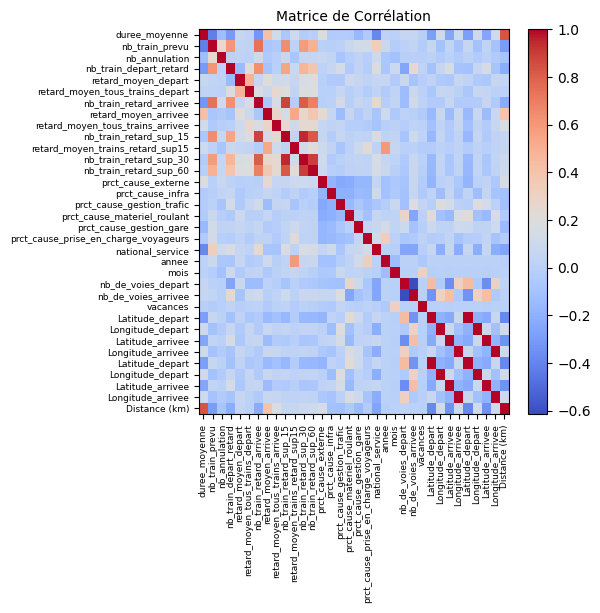

In [161]:
correlation_matrix = merged_data.corr()

plt.figure(figsize=(5, 5))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none',aspect='auto')
plt.colorbar()
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90, fontsize=6.5)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, fontsize= 6.5)
plt.title('Matrice de Corrélation', fontsize= 10)
plt.show()

In [163]:

def top_correlation(number_of_corr):
    # Tri de la matrice de corrélation en un DataFrame
    correlation_df = pd.DataFrame(correlation_matrix.unstack().sort_values(ascending=False), columns=['correlation'])

    # Supprimez les corrélations de 1.0
    correlation_df = correlation_df[correlation_df['correlation'] < 1.0]

    # Afficher les corrélations les plus fortes
    top_corr = correlation_df.head(number_of_corr)
    print(top_corr)

top_correlation(5)

                                                                   correlation
nb_train_retard_sup_30           nb_train_retard_sup_15               0.945495
nb_train_retard_sup_15           nb_train_retard_sup_30               0.945495
nb_train_retard_sup_60           nb_train_retard_sup_30               0.896712
nb_train_retard_sup_30           nb_train_retard_sup_60               0.896712
nb_train_retard_arrivee          nb_train_retard_sup_15               0.886350
nb_train_retard_sup_15           nb_train_retard_arrivee              0.886350
duree_moyenne                    Distance (km)                        0.831668
Distance (km)                    duree_moyenne                        0.831668
nb_train_retard_sup_60           nb_train_retard_sup_15               0.819064
nb_train_retard_sup_15           nb_train_retard_sup_60               0.819064
nb_train_retard_arrivee          nb_train_retard_sup_30               0.808876
nb_train_retard_sup_30           nb_train_retard_arr

On remarque que la corrélation s'effectue surtout sur les partie retard de trains entreux.  
Nous allons donc essayer de le faire sans avoir ses colonnes qui sont corrélés mais nous le savions. 

C:\Users\MatyG\AppData\Local\Temp\ipykernel_13420\734577840.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix_drop_column = data_without_late_train.corr()


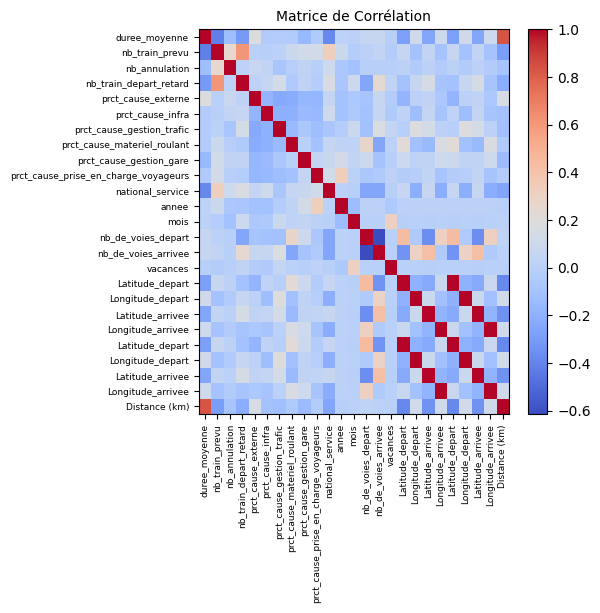

In [165]:
columns_to_drop = ['retard_moyen_depart','retard_moyen_tous_trains_depart',
                   'nb_train_retard_arrivee','retard_moyen_arrivee','retard_moyen_tous_trains_arrivee',
                   'nb_train_retard_sup_15','retard_moyen_trains_retard_sup15','nb_train_retard_sup_30',
                   'nb_train_retard_sup_60']
data_without_late_train = merged_data.drop(columns=columns_to_drop)

correlation_matrix_drop_column = data_without_late_train.corr()

plt.figure(figsize=(5, 5))
plt.imshow(correlation_matrix_drop_column, cmap='coolwarm', interpolation='none',aspect='auto')
plt.colorbar()
plt.xticks(range(len(correlation_matrix_drop_column.columns)), correlation_matrix_drop_column.columns, rotation=90, fontsize=6.5)
plt.yticks(range(len(correlation_matrix_drop_column.columns)), correlation_matrix_drop_column.columns, fontsize= 6.5)
plt.title('Matrice de Corrélation', fontsize= 10)
plt.show()

In [167]:
def top_correlation(number_of_corr):
    # Tri de la matrice de corrélation en un DataFrame
    correlation_df = pd.DataFrame(correlation_matrix_drop_column.unstack().sort_values(ascending=False), columns=['correlation'])

    # Supprimez les corrélations de 1.0
    correlation_df = correlation_df[correlation_df['correlation'] < 1.0]

    # Afficher les corrélations les plus fortes
    top_corr = correlation_df.head(number_of_corr)
    print(top_corr)

top_correlation(15)

                                                                           correlation
duree_moyenne                        Distance (km)                            0.831668
Distance (km)                        duree_moyenne                            0.831668
nb_train_depart_retard               nb_train_prevu                           0.602848
nb_train_prevu                       nb_train_depart_retard                   0.602848
nb_de_voies_depart                   Latitude_depart                          0.436109
Latitude_depart                      nb_de_voies_depart                       0.436109
                                     nb_de_voies_depart                       0.436109
nb_de_voies_depart                   Latitude_depart                          0.436109
nb_de_voies_arrivee                  Latitude_arrivee                         0.421088
                                     Latitude_arrivee                         0.421088
Latitude_arrivee                     nb_de_

### PARTIE 5 : Exportation de la base de donnée traitée

A faire : 
Sortir une base de donnée par application
- une sans les prct
- une sans trop de colonnes pour prédire le retard moyen


In [136]:
merged_data.to_csv('csv_files/train_bdd_clean.csv', index=False)